# Helper functions for the de-dispersion code

### Aug 03, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
# import pyrex.custom.analysis
# import pyrex.custom.araroot as araroot



Welcome to JupyROOT 6.18/04


In [181]:
import pyrex.custom.ara as ara
from pyrex.internal_functions import (normalize, complex_bilinear_interp,
                                      complex_interp)

In [3]:
# ara_antenna = ara.antenna.VPOL_RESPONSE_DATA
VPOL_DATA_FILE = os.path.join(ara.antenna.ARA_DATA_DIR,
                              "ARA_bicone6in_output_MY_fixed.txt")
VPOL_THETA_RESPONSE_DATA = ara.antenna._read_arasim_antenna_data(VPOL_DATA_FILE)
VPOL_RESPONSE_DATA = (
    VPOL_THETA_RESPONSE_DATA[0],
    np.zeros(VPOL_THETA_RESPONSE_DATA[0].shape),
    *VPOL_THETA_RESPONSE_DATA[1:]
)
ara_antenna = VPOL_RESPONSE_DATA

theta_response = ara_antenna[0]
phi_response = ara_antenna[1]
response_freqs = ara_antenna[2]
response_zens = ara_antenna[3]
response_azis = ara_antenna[4]

In [4]:
def directional_response(theta, phi, polarization):
        """
        Generate the (complex) frequency-dependent directional response.
        For given angles and polarization direction, use the model of the
        directional and polarization gains of the antenna to generate a
        function for the interpolated response of the antenna with respect to
        frequency. Used with the `frequency_response` method to calculate
        effective heights.
        Parameters
        ----------
        theta : float
            Polar angle (radians) from which a signal is arriving.
        phi : float
            Azimuthal angle (radians) from which a signal is arriving.
        polarization : array_like
            Normalized polarization vector in the antenna coordinate system.
        Returns
        -------
        function
            A function which returns complex-valued voltage gains for given
            frequencies, using the values of incoming angle and polarization.
        See Also
        --------
        ARAAntenna.frequency_response : Calculate the (complex) frequency
                                        response of the antenna.
        """
        e_theta = [np.cos(theta) * np.cos(phi),
                   np.cos(theta) * np.sin(phi),
                   -np.sin(theta)]
        e_phi = [-np.sin(phi), np.cos(phi), 0]
        theta_factor = np.dot(polarization, e_theta)
        phi_factor = np.dot(polarization, e_phi)
        theta_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=theta_response,
            method='cartesian'
        )
        phi_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=phi_response,
            method='cartesian'
        )
        freq_interpolator = lambda frequencies: complex_interp(
            x=frequencies, xp=response_freqs,
            fp=theta_factor*theta_gains + phi_factor*phi_gains,
            method='euler', outer=0
        )
        return freq_interpolator
    
def frequency_response(frequencies):
    """
    Calculate the (complex) frequency response of the antenna.
    Rather than handling the entire frequency response of the antenna, this
    method is being used to convert the frequency-dependent gains from the
    `directional_response` method into effective heights.
    Parameters
    ----------
    frequencies : array_like
        1D array of frequencies (Hz) at which to calculate gains.
    Returns
    -------
    array_like
        Complex gains in voltage for the given `frequencies`.
    See Also
    --------
    ARAAntenna.directional_response : Generate the (complex) frequency
                                      dependent directional response.
    """
    # From AraSim GaintoHeight function, with gain calculation moved to
    # the directional_response method.
    # gain=4*pi*A_eff/lambda^2 and h_eff=2*sqrt(A_eff*Z_rx/Z_air)
    # Then 0.5 to calculate power with heff (cancels 2 above)
    heff = np.zeros(len(frequencies))
    # The index of refraction in this calculation should be the index of
    # the ice used in the production of the antenna model.
    n = 1.78
    heff[frequencies!=0] = np.sqrt((3e8/frequencies[frequencies!=0]/n)**2
                                   * n*50/377 /(4*np.pi))
    return heff

## Examine pickle

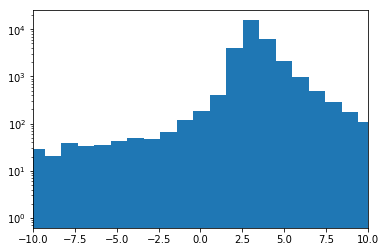

In [6]:
unpickled_df = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/angles.pkl")
unpickled_df = unpickled_df.dropna()
# plt.hist(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"])
plt.hist(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"], bins=300);
plt.xlim(-10,10)
plt.yscale('log')

In [7]:
mean = (unpickled_df["theta_antenna"]-unpickled_df["theta_reco"]).mean()

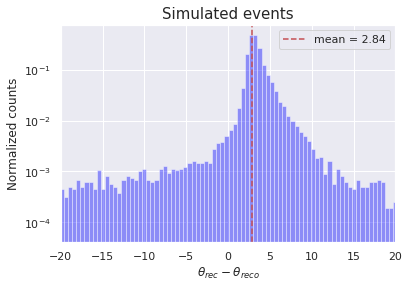

In [34]:
import seaborn as sns
from scipy import stats
plt.axvline(mean, color='r', linestyle='--', label = "mean = %0.2f"%mean)
sns.set(color_codes=True)
sns.distplot(unpickled_df["theta_antenna"]-unpickled_df["theta_reco"], bins=600, kde=False, color="blue", norm_hist=True);
plt.xlim(-20,20)
plt.yscale('log')
plt.ylabel("Normalized counts")
plt.xlabel("$\\theta_{rec}-\\theta_{reco}$")
plt.title("Simulated events", fontsize = 15)
plt.legend()
plt.savefig("./plots/sim_RecovsRec_theta_fixed.pdf")

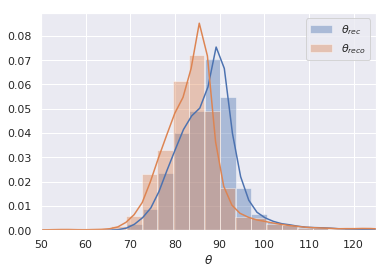

In [30]:
sns.distplot(unpickled_df["theta_antenna"], kde=True, norm_hist=True, label="$\\theta_{rec}$");
sns.distplot(unpickled_df["theta_reco"], kde=True, norm_hist=True,label="$\\theta_{reco}$");
plt.xlim(50, 125)
plt.xlabel("$\\theta$")
plt.legend()

## Debug FFT

1280

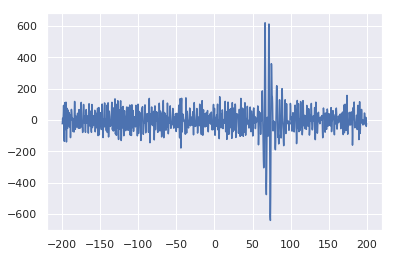

In [62]:
wform = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/wform_forDebug.pkl")
plt.plot(wform["time"], wform.voltage)
len(wform.voltage)

In [65]:
import scipy
fft = abs(scipy.fft.rfft(np.array(wform["voltage"])))
freq = 1000*scipy.fft.rfftfreq(n=len(wform["time"]), d=wform["time"][1]-wform["time"][0])

(0, 1000)

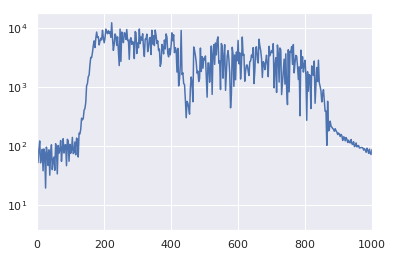

In [66]:
plt.plot(freq,fft, label="Direct")
plt.yscale('log')
plt.xlim(0,1000)

### FFT function

In [427]:
def doFFT(time, volts):
    fft = scipy.fft.rfft(np.array(volts))
    dT = abs(time[1]-time[0])
    freq = 1000*scipy.fft.rfftfreq(n=len(time), d=dT)
    return fft, freq, dT
    

200.0

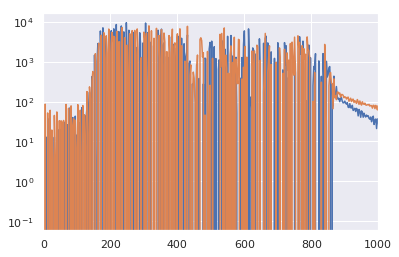

In [180]:
fft_v, fft_f, dT = doFFT(wform["time"],wform["voltage"])
plt.plot(fft_f,fft_v.real, label="Direct")
plt.plot(fft_f,fft_v.imag, label="Direct")

plt.yscale('log')
plt.xlim(0,1000)
dT*len(wform["time"])/2

### Inverse FFT

0.4

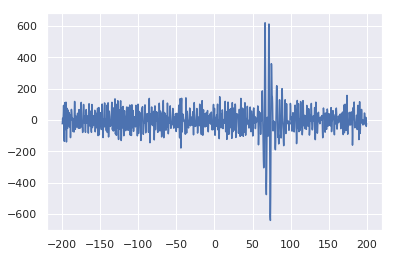

In [259]:
fft_i_v= scipy.fft.irfft(fft_v)
plt.plot(wform["time"],fft_i_v, label="Direct")
# fft_d_i = np.roll(fft_i_v, len(fft_i_v))
1/(fft_f[1]-fft_f[0])

In [263]:
def doInvFFT(spectrum):
    fft_i_v= scipy.fft.irfft(spectrum)
    return fft_i_v
    

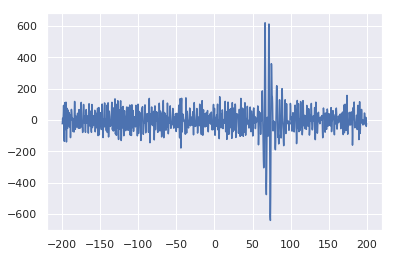

In [264]:
fft_i_v_test= doInvFFT(fft_v)
plt.plot(wform["time"],fft_i_v_test, label="Direct")

## Get filter response

In [194]:
def interpolate_filter(frequencies):
        """
        Generate interpolated filter values for given frequencies.
        Calculate the interpolated values of the antenna system's filter gain
        data for some frequencies.
        Parameters
        ----------
        frequencies : array_like
            1D array of frequencies (Hz) at which to calculate gains.
        Returns
        -------
        array_like
            Complex filter gain in voltage for the given `frequencies`.
        """
        ARAfilter = ara.antenna.ALL_FILTERS_DATA
        filt_response = ARAfilter[0]
        filt_freqs = ARAfilter[1]
        return complex_interp(
            x=frequencies, xp=filt_freqs, fp=filt_response,
            method='euler', outer=0
        )

In [200]:
f_Freq = 1E9*np.linspace(0,1,1000)
# f_Freq
f_Resp = interpolate_filter(f_Freq)

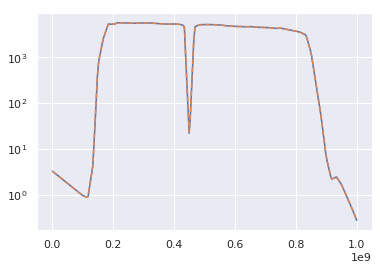

In [305]:
# plt.plot(filt_freqs,filt_response.imag)
# plt.plot(filt_freqs,filt_response.real)
plt.plot(filt_freqs,abs(filt_response))
plt.plot(f_Freq,abs(f_Resp), "--")
plt.yscale('log')

## Test filter de-dispersion

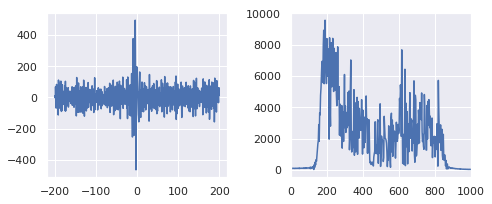

In [503]:
wform = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/wform_forDebug.pkl")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

axes[0].plot(wform["time"], wform.voltage)

fft_v, fft_f, dT = doFFT(wform["time"],wform["voltage"])
axes[1].plot(fft_f,abs(fft_v), label="Direct")
axes[1].set_xlim(0,1000)

plt.tight_layout()

/users/PCON0003/cond0068/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


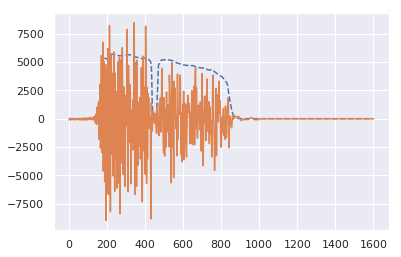

In [441]:
#   FFTWComplex r = response[i]; 
#     r/= r.getAbs(); 
#     Y[i]/=r; 
response = np.array(interpolate_filter(fft_f*1E6))
# plt.plot(fft_f,response.real)
# plt.plot(fft_f,response.imag)
# plt.plot(filt_freqs,abs(filt_response))
plt.plot(fft_f,abs(response), "--")
# plt.plot(fft_f,abs(fft_v), label="Direct")
response = np.divide(response,abs(response))
deDis_wf_f = np.divide(fft_v,response)
deDis_wf_f = np.nan_to_num(deDis_wf_f)
plt.plot(fft_f,deDis_wf_f)

In [442]:
np.zeros_like(abs(1))

array(0)

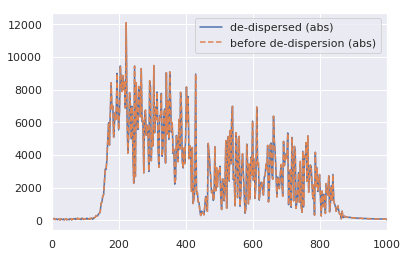

In [443]:
plt.plot(fft_f,abs(deDis_wf_f),label="de-dispersed (abs)" )
plt.plot(fft_f,abs(fft_v), "--", label='before de-dispersion (abs)')
plt.xlim(0,1000)
plt.legend()

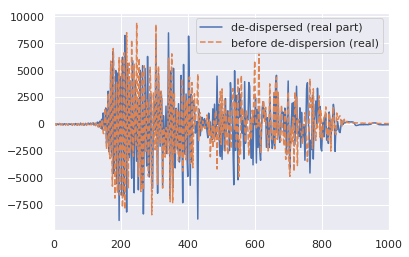

In [444]:
plt.plot(fft_f,deDis_wf_f.real, label="de-dispersed (real part)")
plt.plot(fft_f,fft_v.real, "--", label='before de-dispersion (real)')
plt.xlim(0,1000)
plt.legend()

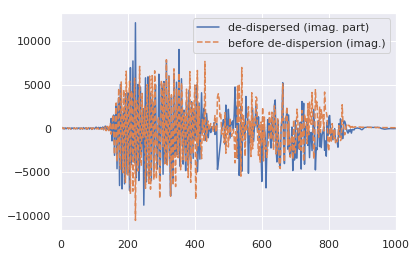

In [445]:
plt.plot(fft_f,deDis_wf_f.imag, label="de-dispersed (imag. part)")
plt.plot(fft_f,fft_v.imag, "--", label='before de-dispersion (imag.)')
plt.xlim(0,1000)
plt.legend()

(0, 100)

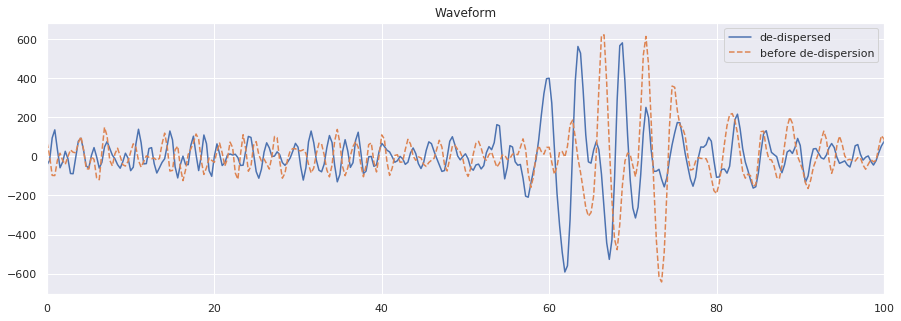

In [446]:
plt.figure(figsize=(15,5))
deDis_wf_t = doInvFFT(deDis_wf_f)
plt.plot(wform["time"],deDis_wf_t,label = "de-dispersed")
plt.plot(wform["time"], wform.voltage, '--', label = 'before de-dispersion')
plt.title("Waveform")
plt.legend()
plt.xlim(0,100)

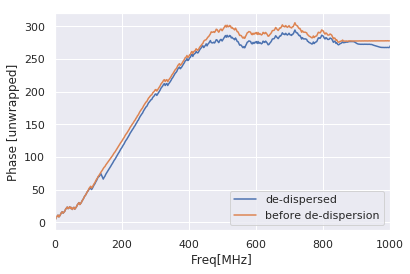

In [390]:
plt.plot(fft_f,np.unwrap(np.angle(deDis_wf_f)),label = "de-dispersed")
plt.plot(fft_f,np.unwrap(np.angle(fft_v)),label = "before de-dispersion")
plt.xlabel("Freq[MHz]")
plt.ylabel("Phase [unwrapped]")
plt.xlim(0,1000)
plt.legend()

## Define de-dispersion function

In [504]:
def deDisperse(time, voltage):
    fft_v, fft_f, dT = doFFT(time,voltage)
#     plt.plot(fft_f, abs(fft_v))
    response = np.array(interpolate_filter(fft_f*1E6))
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(fft_v,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    deDis_wf = doInvFFT(deDis_wf)
    return time, deDis_wf


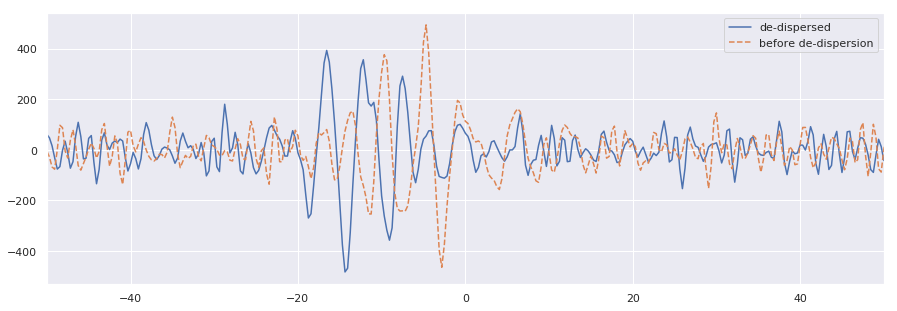

In [511]:
plt.figure(figsize=(15,5))

deD_t, deD_v = deDisperse(wform["time"], wform.voltage)
plt.plot(deD_t,deD_v,label = "de-dispersed")
plt.plot(wform["time"], wform.voltage,"--", label = 'before de-dispersion')
plt.xlim(-50,50)
plt.legend()

## Example

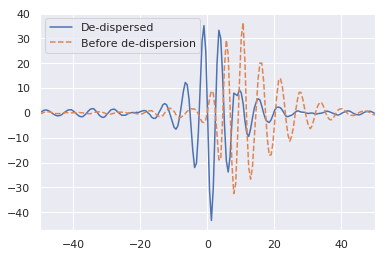

In [452]:
direct = pd.read_csv("/users/PCON0003/cond0068/ARA/AraSim/debug/waveform_antenna_dir.csv")
deD_t, deD_v = deDisperse(direct["time"], direct.voltage*1E3)
plt.plot(deD_t,deD_v, label = "De-dispersed")
plt.plot(direct['time'], direct["voltage"]*1E3, "--",label = "Before de-dispersion")
plt.xlim(-50,50)
plt.legend()


## Plots

In [512]:
b, a = signal.butter(2, 0.6)
response = signal.lfilter(b, a, imp)
imp = signal.unit_impulse(100, 'mid')

sig = pyrex.Signal(np.arange(-50, 50),imp) # times in seconds
from scipy import signal
ant = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
output = ant.front_end(sig)

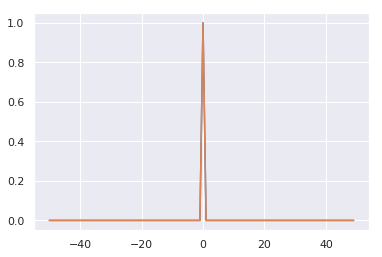

In [514]:

plt.plot(np.arange(-50, 50), imp)
# plt.plot(np.arange(-50, 50),imp)
plt.plot(output.times, output.values)
# output.times

## Comments